In [1]:
import numpy as np

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as T

from barlow_twins import BarlowTwins

from augmentation import apply_transforms_inf
from short_video_dataset import ShortVideoDataset
from time_dataset import ShortVideoDatasetTime

In [2]:
model = torch.load('models/model_time.pth')

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)

cuda


BarlowTwins(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [4]:
dataset = ShortVideoDatasetTime('video_short_half_res', transform=T.Compose([
    T.Resize(64),
    T.ToTensor(),
    T.Grayscale()
]))

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    # drop_last=True,
    num_workers=1,
)

In [5]:
embeddings = []

model.eval()
for index, image in dataloader:
    image = image.to(device)
    emb = model(image).cpu().detach().flatten()

    embeddings.append(np.array(emb))

In [6]:
len(embeddings)

544

In [7]:
embeddings = np.array(embeddings)

## PCA

In [8]:
from sklearn.decomposition import PCA

In [9]:
mean_emb = embeddings.mean(axis=0)
std_emb = embeddings.std(axis=0) 
emb_norm = (embeddings - mean_emb) / std_emb

In [10]:
emb_norm.mean(), emb_norm.std()

(-1.6541248e-08, 1.0)

In [11]:
pca = PCA(n_components=2, svd_solver='full')
pca.fit(emb_norm)

embeddings_red = pca.transform(emb_norm)
X, Y = embeddings_red[:,0], embeddings_red[:,1]

/home/yasin/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: overflow encountered in square
  explained_variance_ = (S ** 2) / (n_samples - 1)
/home/yasin/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [12]:
import matplotlib.pyplot as plt

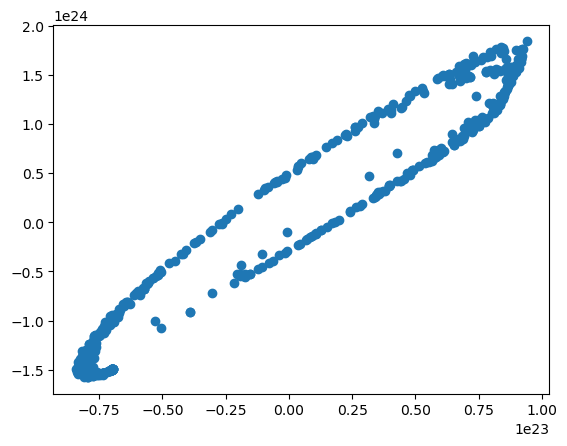

In [13]:
plt.scatter(X, Y)

In [14]:
X_sorted = sorted(list(zip(X, range(len(X)))), key= lambda x: x[0])

## Nearest Neighbours

In [15]:
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1 import ImageGrid

In [16]:
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(embeddings)

NearestNeighbors(n_neighbors=10)

In [17]:
random_index = np.random.randint(len(embeddings))
neigh.kneighbors(embeddings[random_index].reshape(1,-1), 10, return_distance=False)

array([[413, 342, 324, 492, 341, 340, 362, 536, 322, 348]])

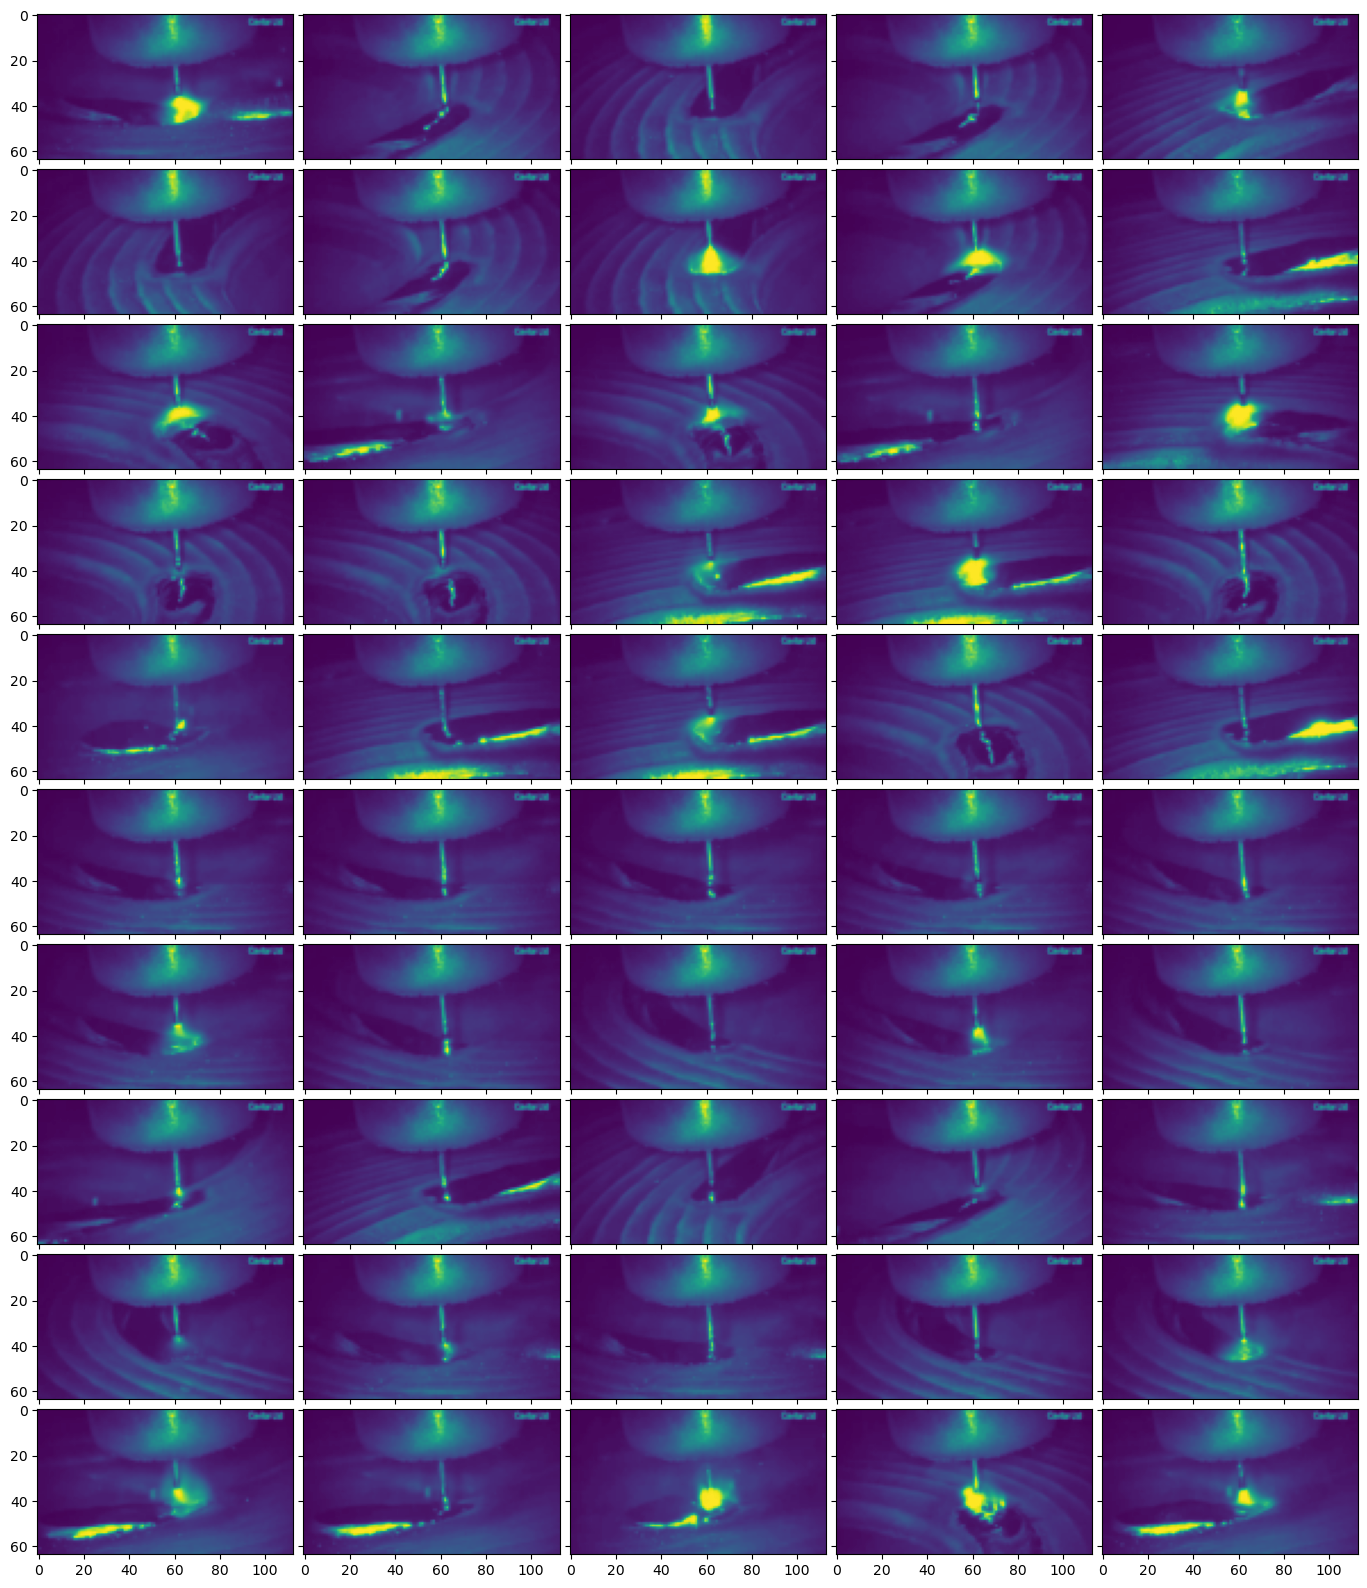

In [20]:
num_samples = 10
num_neighb = 5

fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111, nrows_ncols=(10,num_neighb), axes_pad=0.1)

for r in range(num_samples):
    random_index = np.random.randint(len(embeddings))
    neighb_index = neigh.kneighbors(embeddings[random_index].reshape(1,-1), num_neighb, return_distance=False)

    for c in range(len(neighb_index[0])):
        _, im = dataset.__getitem__(neighb_index[0][c], training=False)
        im = im.swapaxes(0,-1).swapaxes(0,1)
        grid[num_neighb*r+c].imshow(im, )

In [19]:
# fig = plt.figure(figsize=(200,200))
# grid = ImageGrid(fig, 111, nrows_ncols=(100, 5), axes_pad=0.1)

# for ax, (_, i) in zip(grid, X_sorted):
#     _, im = dataset.__getitem__(i, training=False)
#     im = im.swapaxes(0,-1).swapaxes(0,1)
#     ax.imshow(im)

Error in callback <function flush_figures at 0x7feb7c36cdc0> (for post_execute):


KeyboardInterrupt: 